# Load data

In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as K
import keras_tuner as kt

from utils import get_train_data

In [ ]:
if sys.platform == "linux":
    physical_devices = tf.config.experimental.list_physical_devices("GPU")
    if len(physical_devices) > 0:
        print('GPU detected')
        tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPU detected


2022-02-16 07:40:42.930226: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 07:40:43.096720: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 07:40:43.097674: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [ ]:
X_train, y_train = get_train_data(skip_midpoints=True)

id2_hook_2 reversed: False data shape: (1041, 34)
--------------------
id1_hook_1 reversed: False data shape: (858, 34)
--------------------
id0_hook_1 reversed: False data shape: (1100, 34)
--------------------
id3_hook_1 reversed: False data shape: (1461, 34)
--------------------
id2_hook_1 reversed: False data shape: (1013, 34)
--------------------
id3_hook_2 reversed: False data shape: (1297, 34)
--------------------
id0_hook_2 reversed: False data shape: (1051, 34)
--------------------
id1_hook_2 reversed: False data shape: (792, 34)
--------------------
id4_hook_1 reversed: False data shape: (1054, 34)
--------------------
id4_hook_2 reversed: False data shape: (1059, 34)
--------------------
id1_jab_1 reversed: False data shape: (802, 34)
--------------------
id2_jab_2 reversed: False data shape: (1030, 34)
--------------------
id3_jab_2 reversed: False data shape: (1164, 34)
--------------------
id4_jab_1 reversed: False data shape: (911, 34)
--------------------
id0_jab_1 reve

In [ ]:
X_train.shape, y_train.shape

((31074, 34), (31074,))

In [ ]:
def compute_vector_angle(p0, p1, p2):
    # vector p0 - p1
    v1 = p0 - p1
    
    # vector p0 - p2
    v2 = p2 - p1
    
    v1_length = np.sqrt(v1[0] ** 2 + v1[1] ** 2)
    v2_length = np.sqrt(v2[0] ** 2 + v2[1] ** 2)
    
    cos = (v1[0] * v2[0] + v1[1] * v2[1]) / (v1_length * v2_length)
    
    if cos < -1:
        cos = -1
        
    if cos > 1:
        cos = 1

    return np.arccos(cos)


assert np.round(compute_vector_angle(np.array([2, 6]), np.array([0, 0]), np.array([8, 4])), 2) == 0.79

def add_angles(keypoints):
    return np.append(
        keypoints,
        [
            compute_vector_angle(keypoints[10:12], keypoints[14:16], keypoints[18:20]), # angle between left shoulder and wrist in radians
            compute_vector_angle(keypoints[12:14], keypoints[16:18], keypoints[20:22]), # angle between right shoulder and wrist in radians
        ])

In [ ]:
X_train = np.apply_along_axis(add_angles, 1, X_train)
X_train.shape

(31074, 36)

In [ ]:
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16,
    'angle': 17,
}

In [ ]:
def format_feature_names(names):
    """"Form list of feature names

    Params:
        names - list of KEYPOINT_DICT keys
        ndims - number of dimensions (x, y, score)
        skip_midpoints - add or omit midpoint coords (x, y, score)

    Returns:
        list of feature names
    """
    feature_names = []
    for name in names:
        if 'angle' in name:
            feature_names.append(name+'-left-arm')
            feature_names.append(name+'-right-arm')
        else:
            feature_names.append(name+'-x')
            feature_names.append(name+'-y')

    return feature_names

In [ ]:
feature_names = format_feature_names(list(KEYPOINT_DICT.keys()))

In [ ]:
df = pd.DataFrame(data=X_train, columns=feature_names)
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
nose-x,31074.0,-0.220691,0.028890,-0.407440,-0.237477,-0.218163,-0.202571,0.361919
nose-y,31074.0,-0.141959,0.060751,-0.467713,-0.185971,-0.143881,-0.103798,0.475557
left_eye-x,31074.0,-0.232318,0.029956,-0.340721,-0.249898,-0.229959,-0.213657,0.359797
left_eye-y,31074.0,-0.139179,0.064997,-0.480470,-0.186218,-0.144911,-0.101038,0.477576
right_eye-x,31074.0,-0.234061,0.030328,-0.344901,-0.252474,-0.230849,-0.215103,0.359336
right_eye-y,31074.0,-0.133812,0.060529,-0.473905,-0.176613,-0.133870,-0.094512,0.475477
left_ear-x,31074.0,-0.233495,0.029593,-0.444675,-0.252486,-0.232580,-0.214265,0.366997
left_ear-y,31074.0,-0.095097,0.068961,-0.451503,-0.144561,-0.108980,-0.052620,0.474723
right_ear-x,31074.0,-0.238615,0.030643,-0.346178,-0.258294,-0.236333,-0.218362,0.363357
right_ear-y,31074.0,-0.080467,0.056187,-0.465192,-0.115846,-0.075599,-0.042123,0.473494


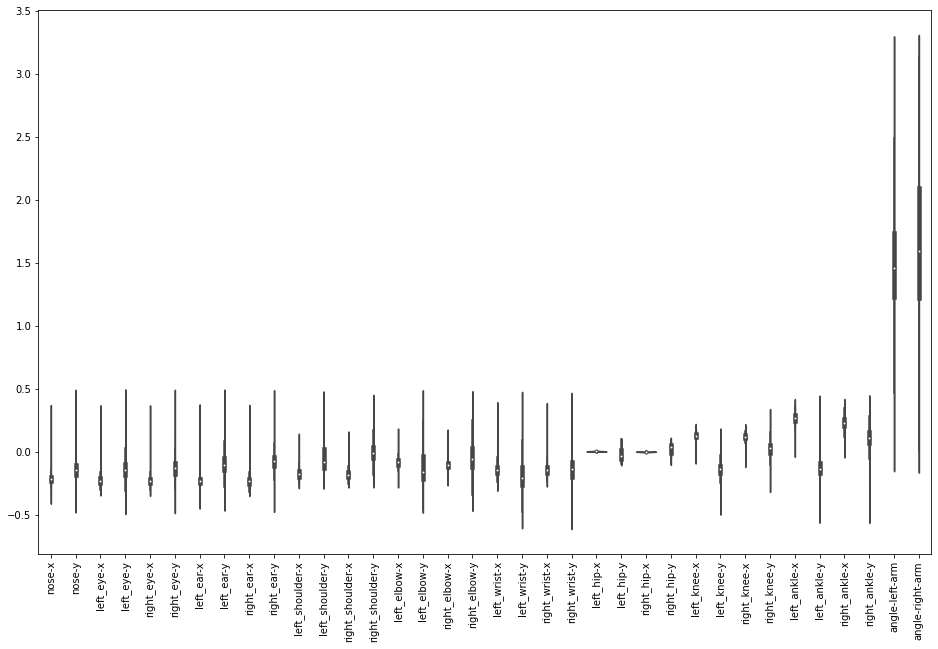

In [ ]:
plt.figure(figsize=(16, 10))
ax = sns.violinplot(data=df)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [ ]:
time_steps=30 # expect camera 30 fps, so process 1 sample per second
# Number of samples in batch
N_train = X_train.shape[0] // time_steps 

In [ ]:
X_train = X_train[:N_train*time_steps].reshape(-1, time_steps, 36)
y_train = y_train[:N_train*time_steps].reshape(-1, time_steps, 1)
X_train.shape

(1035, 30, 36)

## LSTM

In [ ]:
y_train = K.utils.to_categorical(y_train, num_classes=7)
X_train = tf.constant(X_train)

2022-02-16 07:42:06.705991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 07:42:06.707062: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 07:42:06.707911: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 07:42:09.482734: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 07:42:09.483678: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

In [ ]:
def model_builder(hp):
    # Hyperparams
    hp_ru1 = hp.Int('recurrent_units1', min_value=16, max_value=128, step=8)
    hp_ru2 = hp.Int('recurrent_units2', min_value=16, max_value=128, step=8)

    hp_du1 = hp.Int('units1', min_value=16, max_value=128, step=8)
    hp_du2 = hp.Int('units2', min_value=16, max_value=128, step=8)

    hp_reg1 = hp.Float('dense_reg1', min_value=1e-4, max_value=1e-2)
    hp_reg2 = hp.Float('dense_reg2', min_value=1e-4, max_value=1e-2)
    
    hp_dp1 = hp.Float('rec_dropout1', min_value=0., max_value=0.4)
    hp_dp2 = hp.Float('rec_dropout2', min_value=0., max_value=0.4)

    hp_dl_dp = hp.Float('dropout', min_value=0., max_value=0.4)

    hp_rec_dp1 = hp.Float('rec_dropout1', min_value=0., max_value=0.4)
    hp_rec_dp2 = hp.Float('rec_dropout2', min_value=0., max_value=0.4)

    hp_kernel_reg1 = hp.Float('kernel_reg1', min_value=1e-5, max_value=1e-3, sampling='log')
    hp_kernel_reg2 = hp.Float('kernel_reg2', min_value=1e-5, max_value=1e-3, sampling='log')

    hp_recur_reg1 = hp.Float('recur_reg1', min_value=1e-5, max_value=1e-3, sampling='log')
    hp_recur_reg2 = hp.Float('recur_reg2', min_value=1e-5, max_value=1e-3, sampling='log')

    hp_act_reg1 = hp.Float('act_reg1', min_value=1e-5, max_value=1e-3, sampling='log')
    hp_act_reg2 = hp.Float('act_reg2', min_value=1e-5, max_value=1e-3, sampling='log')

    hp_add_another_rec_layer = hp.Boolean('add_another_gru_layer')
 
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2)

    layers = []
    
    # Model
    kernel_reg1 = K.regularizers.l2(hp_kernel_reg1)
    kernel_reg2 = K.regularizers.l2(hp_kernel_reg2)

    recurrent_reg1 = K.regularizers.l2(hp_recur_reg1)
    recurrent_reg2 = K.regularizers.l2(hp_recur_reg2)

    act_reg1 = K.regularizers.l2(hp_act_reg1)
    act_reg2 = K.regularizers.l2(hp_act_reg2)

    model = K.Sequential()
    model.add(K.layers.LayerNormalization(axis=1))
    model.add(K.layers.LSTM(hp_ru1,
                             # stateful=True, # mutable states not supported in tflite 
                             return_sequences=True,
                             kernel_regularizer=kernel_reg1,
                             recurrent_regularizer=recurrent_reg1,
                             activity_regularizer=act_reg1,
                             dropout=hp_dp1,
                             recurrent_dropout=hp_rec_dp1
                           ))

    if hp_add_another_rec_layer:
        model.add(K.layers.LSTM(hp_ru2,
                             # stateful=True, # mutable states not supported in tflite 
                             return_sequences=True,
                             kernel_regularizer=kernel_reg2,
                             recurrent_regularizer=recurrent_reg2,
                             activity_regularizer=act_reg2,
                             dropout=hp_dp2,
                             recurrent_dropout=hp_rec_dp2
                           ))

    model.add(K.layers.Dense(hp_du1, activation='relu',
                            kernel_regularizer=K.regularizers.l2(hp_reg1)))
    model.add(K.layers.Dropout(hp_dl_dp))
    model.add(K.layers.Dense(hp_du2, activation='relu',
                            kernel_regularizer=K.regularizers.l2(hp_reg2))) 
    model.add(K.layers.Dense(7, activation='sigmoid'))

    model.compile(optimizer=K.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=32,
                     directory='kt_dir',
                     project_name='punch_dl_kt_lstm')

stop_early = K.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, batch_size=4, validation_split=0.33, epochs=32, shuffle=False, callbacks=[stop_early])

Trial 79 Complete [00h 04m 20s]
val_accuracy: 0.6902534365653992

Best val_accuracy So Far: 0.7075048685073853
Total elapsed time: 02h 23m 05s

Search: Running Trial #80

Hyperparameter    |Value             |Best Value So Far 
recurrent_units1  |40                |88                
recurrent_units2  |64                |72                
units1            |48                |96                
units2            |88                |56                
dense_reg1        |0.0041705         |0.0096045         
dense_reg2        |0.0088338         |0.0018083         
rec_dropout1      |0.0042331         |0.096328          
rec_dropout2      |0.2961            |0.23795           
dropout           |0.094796          |0.081893          
kernel_reg1       |0.00018516        |1.1431e-05        
kernel_reg2       |0.00083605        |0.00084688        
recur_reg1        |0.00073868        |6.8784e-05        
recur_reg2        |0.00044689        |2.0073e-05        
act_reg1          |0.00012009  

KeyboardInterrupt: 

In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

best_hps.values

{'recurrent_units1': 88,
 'recurrent_units2': 72,
 'units1': 96,
 'units2': 56,
 'dense_reg1': 0.009604536297604199,
 'dense_reg2': 0.001808320235089847,
 'rec_dropout1': 0.09632795128822612,
 'rec_dropout2': 0.2379480750026625,
 'dropout': 0.08189336395421294,
 'kernel_reg1': 1.1430620822819172e-05,
 'kernel_reg2': 0.000846883575748356,
 'recur_reg1': 6.878417140525675e-05,
 'recur_reg2': 2.007332363028893e-05,
 'act_reg1': 5.6292301807085334e-05,
 'act_reg2': 1.9600097198800182e-05,
 'add_another_gru_layer': True,
 'learning_rate': 0.009017516119345596,
 'tuner/epochs': 11,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 1,
 'tuner/round': 0}

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 64 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, batch_size=1,
                    validation_split=0.33, 
                    epochs=48,
                    shuffle=False,
                    callbacks=[
                        K.callbacks.ReduceLROnPlateau(),
                        K.callbacks.ModelCheckpoint(filepath='checkpoints/lstm', save_weights_only=True),
                        K.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
                    ])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/48
693/693 [==============================] - 76s 105ms/step - loss: 1.2308 - accuracy: 0.6222 - val_loss: 2.7291 - val_accuracy: 0.6650
Epoch 2/48
693/693 [==============================] - 76s 109ms/step - loss: 1.1544 - accuracy: 0.6780 - val_loss: 2.8035 - val_accuracy: 0.6688
Epoch 3/48
693/693 [==============================] - 73s 105ms/step - loss: 1.0690 - accuracy: 0.7090 - val_loss: 2.7465 - val_accuracy: 0.6748
Epoch 4/48
693/693 [==============================] - 78s 113ms/step - loss: 1.1461 - accuracy: 0.6824 - val_loss: 3.1000 - val_accuracy: 0.6888
Epoch 5/48
693/693 [==============================] - 72s 104ms/step - loss: 1.0779 - accuracy: 0.7094 - val_loss: 4.2086 - val_accuracy: 0.6831
Epoch 6/48
693/693 [==============================] - 75s 108ms/step - loss: 1.0207 - accuracy: 0.7010 - val_loss: 4.0054 - val_accuracy: 0.6210
Epoch 7/48
693/693 [==============================] - 73s 105ms/step - loss: 1.0764 - accuracy: 0.6595 - val_loss: 3.7509 - val_ac

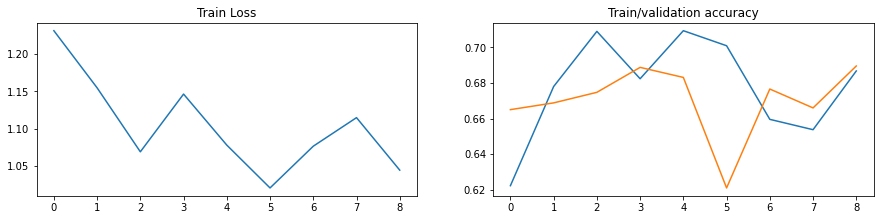

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(221)
plt.title("Train Loss")
plt.plot(history.history['loss'])
plt.subplot(222)
plt.title("Train/validation accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.savefig('imgs/train_val_acc.png', bbox_inches='tight')

# Conclusion 

* need more data to avoid overfitting
* need simpler architecture (2 recurrent layers is too much)
* add dropout layers

# Try

* 2d convolutions
* attention mechanism

# Save model

In [ ]:
model.save('./models/lstm__with_angles')

INFO:tensorflow:Assets written to: /storage/models/lstm__with_angles/assets


INFO:tensorflow:Assets written to: /storage/models/lstm__with_angles/assets
